In [1]:
import awswrangler as wr
import pandas as pd
import numpy as np

In [2]:
# Load the CLEANED dataset we prepared in the previous phase
cleaned_s3_path = "s3://chung-yeh-youbike-poc-data/processed/youbike_data_for_modeling.parquet"
print(f"Loading dataset from {cleaned_s3_path}...")
df = wr.s3.read_parquet(path=cleaned_s3_path)
print("Dataset loaded successfully!")

df.reset_index(inplace=True)

Loading dataset from s3://chung-yeh-youbike-poc-data/processed/youbike_data_for_modeling.parquet...
Dataset loaded successfully!


## Advanced Feature Engineering (Lags & Rolling Windows)

The previous training shows that the current model only knows the state of the station right now. It has no sense of momentum or recent history.  Adding features that describe the recent past will give it a massive performance boost:
- Lag Features: Create columns for what the available_rent_bikes were 5, 10, and 15 minutes ago.
- Rolling Window Features: Create columns for the average, min, and max available_rent_bikes over the last 30 minutes or hour. This tells the model what the recent trend has been.

In [3]:
# Create Lag & Rolling Window Features
features_to_engineer = ['available_rent_bikes', 'available_return_bikes']
lag_steps = [1, 2, 3, 6] 
rolling_window_size = 6 

for col in features_to_engineer:
    print(f"Engineering advanced features for column: {col}")
    for step in lag_steps:
        df[f'{col}_lag_{step}'] = df.groupby('sno')[col].shift(step)
    
   
    rolling_window = df.groupby('sno')[col].rolling(window=rolling_window_size)
    df[f'{col}_rolling_mean'] = rolling_window.mean().values
    df[f'{col}_rolling_std'] = rolling_window.std().values
    df[f'{col}_rolling_min'] = rolling_window.min().values
    df[f'{col}_rolling_max'] = rolling_window.max().values

# Drop rows with NaN values created by the shifting and rolling operations
df.dropna(inplace=True)

print("\nFeature engineering complete.")
print("New DataFrame shape:", df.shape)

Engineering advanced features for column: available_rent_bikes
Engineering advanced features for column: available_return_bikes

Feature engineering complete.
New DataFrame shape: (2165151, 37)


## Retraining the model

In the initial model, the recall of "FULL" was too low, indicating that the model rarely predict the result as "FULL". Since the importance of this rare class in realizing our goal, we set parameter class_weight = 'balanced' to make the new model more sensitive to the rare classes.

In [4]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### Step 1: Define Features (X) and Target (y)

In [5]:
features = [
    'total', 'available_rent_bikes', 'latitude', 'longitude', 'available_return_bikes',
    'hour', 'day_of_week', 'is_weekend',
    'available_rent_bikes_lag_1', 'available_rent_bikes_lag_2', 'available_rent_bikes_lag_3', 'available_rent_bikes_lag_6',
    'available_rent_bikes_rolling_mean', 'available_rent_bikes_rolling_std', 'available_rent_bikes_rolling_min', 'available_rent_bikes_rolling_max',
    'available_return_bikes_lag_1', 'available_return_bikes_lag_2', 'available_return_bikes_lag_3', 'available_return_bikes_lag_6',
    'available_return_bikes_rolling_mean', 'available_return_bikes_rolling_std', 'available_return_bikes_rolling_min', 'available_return_bikes_rolling_max'
]
target = 'status_in_15_mins'

X = df[features]
y = df[target]

# Convert categorical target to numerical codes
y = y.astype('category')
label_map = dict(enumerate(y.cat.categories))
y_codes = y.cat.codes

Defining features and target...


### Step 2: Time-Based Data Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_codes, test_size=0.2, shuffle=False
)

### Step 3: Train the Improved LightGBM Model

In [9]:
print("\nTraining Improved LightGBM model...")
# adding class_weight='balanced' to improve the precision of minority class
lgb_clf_improved = lgb.LGBMClassifier(random_state=42, class_weight='balanced')
lgb_clf_improved.fit(X_train, y_train)
print("Model training complete.")


Training Improved LightGBM model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2898
[LightGBM] [Info] Number of data points in the train set: 1732120, number of used features: 24
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Model training complete.


### Step 4: Evaluate the Improved Model


--- Improved Model Classification Report ---
              precision    recall  f1-score   support

       EMPTY       0.58      0.77      0.66     27282
        FULL       0.20      0.90      0.32      9055
     HEALTHY       0.97      0.82      0.89    314983
         LOW       0.71      0.78      0.74     81711

    accuracy                           0.81    433031
   macro avg       0.61      0.82      0.65    433031
weighted avg       0.88      0.81      0.83    433031


--- Improved Model Confusion Matrix ---


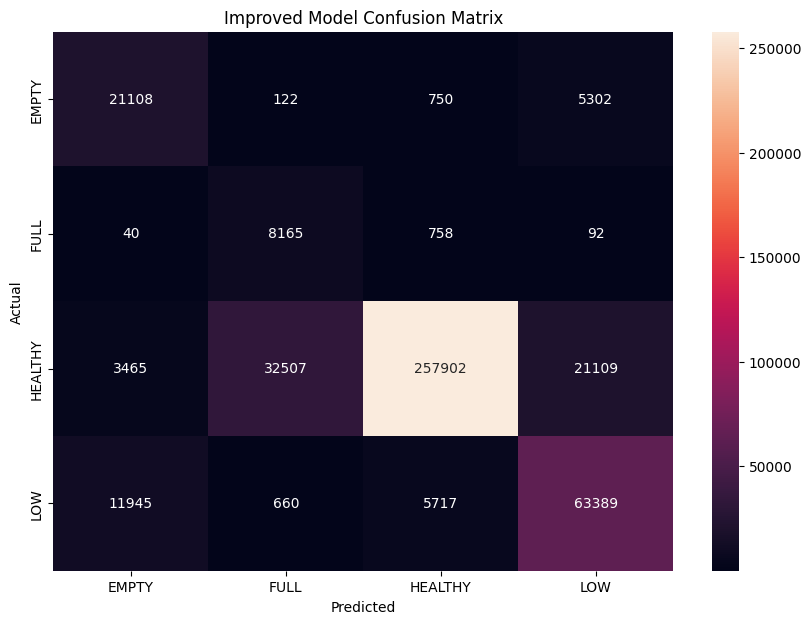

In [11]:
y_pred = lgb_clf_improved.predict(X_test)

# Convert numerical predictions back to original labels
y_test_labels = [label_map[i] for i in y_test]
y_pred_labels = [label_map[i] for i in y_pred]

# Print the classification report
print("\n--- Improved Model Classification Report ---")
print(classification_report(y_test_labels, y_pred_labels))

# Display the confusion matrix
print("\n--- Improved Model Confusion Matrix ---")
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=list(label_map.values()))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(label_map.values()), yticklabels=list(label_map.values()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Improved Model Confusion Matrix')
plt.show()